In [1]:
import sys
sys.path.append("../../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
# from utils import display_matrix
from debug.debug import *
from visualization import *
# matplotlib.use('Agg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

mnist_dset_train = torchvision.datasets.MNIST('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.MNIST('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

# Possible Hyperparameter Selections are Commented Below

In [4]:
## The below works fine with xavier weight initialization. It reaches to 2-3% train and test errors
# activation = hard_sigmoid
# architecture = [784, 500, 10]

# beta = 1
# lambda_ = 0.99995
# epsilon = 0.15
# one_over_epsilon = 1 / epsilon
# lr_start = {'ff' : np.array([0.3, 0.15]), 'fb': np.array([0.15, 0.1])}

# neural_lr_start = 0.1
# neural_lr_stop = 0.001
# neural_lr_rule = "constant"
# neural_lr_decay_multiplier = 0.01
# neural_dynamic_iterations_nudged = 10
# neural_dynamic_iterations_free = 20
# hopfield_g = 0.05

# use_random_sign_beta = False
# use_three_phase = True
# n_epochs = 20

## The following is not bad. It reaches to (Epoch : 20, Train Accuracy : 0.9647166666666667, Test Accuracy : 0.9558)

# activation = hard_sigmoid
# architecture = [784, 128, 64, 10]

# beta = 1
# lambda_ = 0.99995
# epsilon = 0.15
# one_over_epsilon = 1 / epsilon
# lr_start = {'ff' : np.array([0.25, 0.15, 0.1]), 'fb': np.array([0.1, 0.05, 0.05])}

# neural_lr_start = 0.1
# neural_lr_stop = 0.001
# neural_lr_rule = "constant"
# neural_lr_decay_multiplier = 0.01
# neural_dynamic_iterations_nudged = 10
# neural_dynamic_iterations_free = 20
# hopfield_g = 0.05

# use_random_sign_beta = False
# use_three_phase = True
# n_epochs = 20


## The below is not that bad

# activation = hard_sigmoid
# architecture = [784, 128, 64, 10]

# beta = 1
# lambda_ = 0.9999
# epsilon = 0.15
# one_over_epsilon = 1 / epsilon
# lr_start = {'ff' : np.array([0.25, 0.15, 0.15]), 'fb': np.array([np.nan, 0.05, 0.05])}

# neural_lr_start = 0.1
# neural_lr_stop = 0.001
# neural_lr_rule = "constant"
# neural_lr_decay_multiplier = 0.01
# neural_dynamic_iterations_nudged = 10
# neural_dynamic_iterations_free = 20
# hopfield_g = 0.05

# use_random_sign_beta = False
# use_three_phase = True
# n_epochs = 20

In [20]:
def linear(x):
    return x

activation = hard_sigmoid
architecture = [784, 500, 10]

beta = 1
lambda_ = 0.99995
epsilon = 0.15
one_over_epsilon = 1 / epsilon
lr_start = {'ff' : np.array([0.3, 0.15]), 'fb': np.array([0.15, 0.1])}

neural_lr_start = 0.1
neural_lr_stop = 0.001
neural_lr_rule = "constant"
neural_lr_decay_multiplier = 0.01
neural_dynamic_iterations_nudged = 10
neural_dynamic_iterations_free = 30
hopfield_g = 0.05

use_random_sign_beta = False
use_three_phase = True
n_epochs = 20

model = ContrastiveCorInfoMaxHopfield(architecture = architecture, lambda_ = lambda_, 
                                       epsilon = epsilon, activation = activation)

In [10]:
# def linear(x):
#     return x

# activation = hard_sigmoid
# architecture = [784, 500, 10]

# beta = 0.1
# lambda_ = 0.99995
# epsilon = 0.15
# one_over_epsilon = 1 / epsilon
# lr_start = {'ff' : np.array([0.001, 0.001]), 'fb': np.array([0.001, 0.0005])}

# neural_lr_start = 0.1
# neural_lr_stop = 0.001
# neural_lr_rule = "constant"
# neural_lr_decay_multiplier = 0.01
# neural_dynamic_iterations_nudged = 10
# neural_dynamic_iterations_free = 30
# hopfield_g = 0.05

# use_random_sign_beta = False
# use_three_phase = False
# n_epochs = 20

# model = ContrastiveCorInfoMaxHopfield2(architecture = architecture, lambda_ = lambda_, 
#                                        epsilon = epsilon, activation = activation)

In [11]:
# def append_ones_row_vector_to_tensor(inp_vector):
#     return torch.cat((inp_vector, torch.ones(1, inp_vector.shape[1]).to(inp_vector.device)), 0)

In [12]:
# x, y = next(iter(train_loader))
# x, y = x.to(device), y.to(device)
# x = x.view(x.size(0),-1).T
# y_one_hot = F.one_hot(y, 10).to(device).T
# print(model.B[0]['weight'][:-1].shape)
# neurons = model.init_neurons(x.size(1), device = model.device)

# torch.cat((neurons[0], torch.ones(1, neurons[0].shape[1]).to(device)), 0).shape
# append_ones_row_vector_to_tensor(neurons[0]).shape

In [21]:
_ = evaluateContrastiveCorInfoMaxHopfield(model, train_loader, hopfield_g,
                                          neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                          neural_lr_decay_multiplier, 
                                          neural_dynamic_iterations_free, device)

Train accuracy :	 0.07006666666666667


In [22]:
trn_acc_list = []
tst_acc_list = []

for epoch_ in range(n_epochs):
    lr = {'ff' : lr_start['ff'] * (0.95)**epoch_, 'fb' : lr_start['fb'] * (0.95)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T
        
        take_debug_logs_ = (idx % 500 == 0)
        if use_random_sign_beta:
            rnd_sgn = 2*np.random.randint(2) - 1
            beta = rnd_sgn*beta
            
        neurons = model.batch_step_hopfield( x, y_one_hot, hopfield_g, 
                                             lr, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                             neural_lr_decay_multiplier, neural_dynamic_iterations_free,
                                             neural_dynamic_iterations_nudged, beta, 
                                             use_three_phase, take_debug_logs_)
    
    trn_acc = evaluateContrastiveCorInfoMaxHopfield(model, train_loader, hopfield_g, neural_lr_start, 
                                                    neural_lr_stop, neural_lr_rule, 
                                                    neural_lr_decay_multiplier, 
                                                    neural_dynamic_iterations_free, 
                                                    device, printing = False)
    tst_acc = evaluateContrastiveCorInfoMaxHopfield(model, test_loader, hopfield_g, neural_lr_start, 
                                                    neural_lr_stop, neural_lr_rule, 
                                                    neural_lr_decay_multiplier, 
                                                    neural_dynamic_iterations_free, 
                                                    device, printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))
#     print("Free Information ratio: {}".format(np.array(model.layerwise_forward_corinfo_list_free)[-1] / np.array(model.layerwise_backward_corinfo_list_free)[-1]))
    print("Nudged Information ratio: {}".format(np.array(model.layerwise_forward_corinfo_list_nudged)[-1] / np.array(model.layerwise_backward_corinfo_list_nudged)[-1]))

3000it [01:41, 29.48it/s]
0it [00:00, ?it/s]

Epoch : 1, Train Accuracy : 0.9086833333333333, Test Accuracy : 0.9111
Nudged Information ratio: [0.10157576]


3000it [01:40, 29.99it/s]
0it [00:00, ?it/s]

Epoch : 2, Train Accuracy : 0.9328333333333333, Test Accuracy : 0.9323
Nudged Information ratio: [0.09514641]


3000it [01:40, 29.75it/s]
0it [00:00, ?it/s]

Epoch : 3, Train Accuracy : 0.9426833333333333, Test Accuracy : 0.9415
Nudged Information ratio: [0.08972153]


3000it [01:41, 29.43it/s]
0it [00:00, ?it/s]

Epoch : 4, Train Accuracy : 0.9505166666666667, Test Accuracy : 0.9484
Nudged Information ratio: [0.0731472]


3000it [01:42, 29.32it/s]
0it [00:00, ?it/s]

Epoch : 5, Train Accuracy : 0.9577333333333333, Test Accuracy : 0.9538
Nudged Information ratio: [0.07028019]


3000it [01:41, 29.48it/s]
0it [00:00, ?it/s]

Epoch : 6, Train Accuracy : 0.96155, Test Accuracy : 0.9577
Nudged Information ratio: [0.06698646]


3000it [01:42, 29.25it/s]
0it [00:00, ?it/s]

Epoch : 7, Train Accuracy : 0.9640166666666666, Test Accuracy : 0.9599
Nudged Information ratio: [0.06674856]


3000it [01:41, 29.67it/s]
0it [00:00, ?it/s]

Epoch : 8, Train Accuracy : 0.9665833333333333, Test Accuracy : 0.9612
Nudged Information ratio: [0.05693944]


3000it [01:45, 28.42it/s]
0it [00:00, ?it/s]

Epoch : 9, Train Accuracy : 0.9678166666666667, Test Accuracy : 0.9639
Nudged Information ratio: [0.05394368]


3000it [01:39, 30.00it/s]
0it [00:00, ?it/s]

Epoch : 10, Train Accuracy : 0.9696833333333333, Test Accuracy : 0.9644
Nudged Information ratio: [0.05420568]


3000it [01:40, 29.92it/s]
0it [00:00, ?it/s]

Epoch : 11, Train Accuracy : 0.9704166666666667, Test Accuracy : 0.9656
Nudged Information ratio: [0.04550248]


3000it [01:42, 29.17it/s]
0it [00:00, ?it/s]

Epoch : 12, Train Accuracy : 0.9715666666666667, Test Accuracy : 0.966
Nudged Information ratio: [0.04763709]


3000it [01:42, 29.14it/s]
0it [00:00, ?it/s]

Epoch : 13, Train Accuracy : 0.9726, Test Accuracy : 0.9672
Nudged Information ratio: [0.04460281]


3000it [01:42, 29.32it/s]
0it [00:00, ?it/s]

Epoch : 14, Train Accuracy : 0.97285, Test Accuracy : 0.9672
Nudged Information ratio: [0.04367981]


3000it [02:22, 21.12it/s]
0it [00:00, ?it/s]

Epoch : 15, Train Accuracy : 0.97365, Test Accuracy : 0.967
Nudged Information ratio: [0.04830499]


3000it [02:26, 20.44it/s]
0it [00:00, ?it/s]

Epoch : 16, Train Accuracy : 0.97365, Test Accuracy : 0.9675
Nudged Information ratio: [0.04215997]


3000it [03:01, 16.55it/s]
0it [00:00, ?it/s]

Epoch : 17, Train Accuracy : 0.9746833333333333, Test Accuracy : 0.9682
Nudged Information ratio: [0.04223407]


3000it [04:28, 11.17it/s]
0it [00:00, ?it/s]

Epoch : 18, Train Accuracy : 0.9747166666666667, Test Accuracy : 0.9674
Nudged Information ratio: [0.04430812]


2996it [04:41, 10.64it/s]


KeyboardInterrupt: 

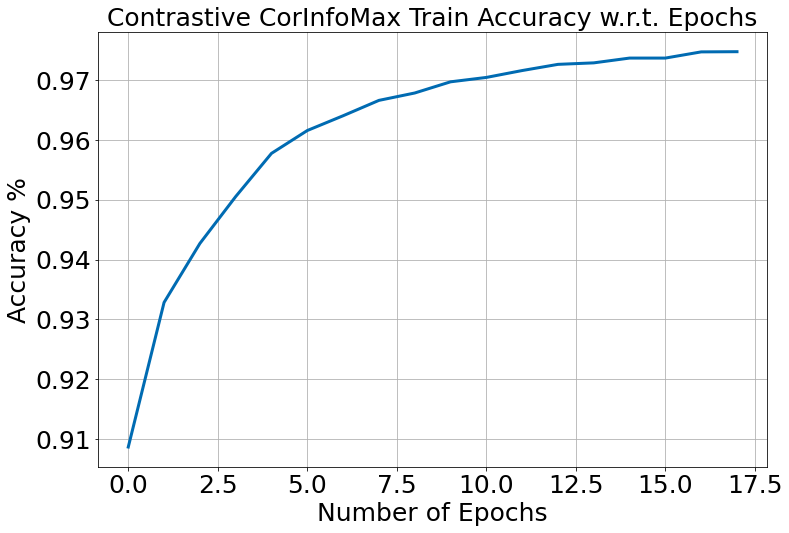

In [23]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

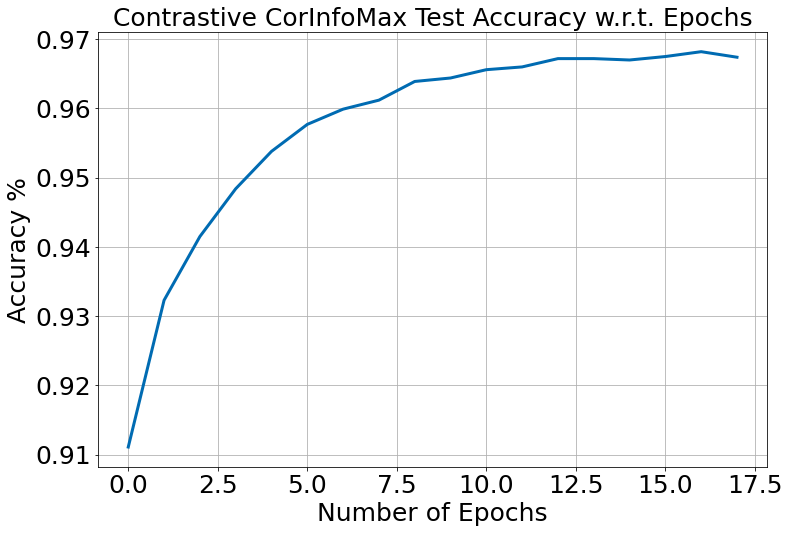

In [24]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

In [25]:
model.forward_backward_angles

[[90.05337524414062],
 [80.75244140625],
 [77.12565612792969],
 [75.20730590820312],
 [73.24803161621094],
 [72.34674072265625],
 [71.66996765136719],
 [71.21923828125],
 [70.84983825683594],
 [70.58256530761719],
 [70.41480255126953],
 [70.22223663330078],
 [70.07157135009766],
 [70.01883697509766],
 [69.94290161132812],
 [69.88470458984375],
 [69.88300323486328],
 [69.89783477783203],
 [69.90805053710938],
 [69.92539978027344],
 [69.99222564697266],
 [70.072998046875],
 [70.19669342041016],
 [70.27629852294922],
 [70.39897918701172],
 [70.4563217163086],
 [70.57157897949219],
 [70.73049926757812],
 [70.8553466796875],
 [70.96251678466797],
 [71.0933609008789],
 [71.26890563964844],
 [71.37238311767578],
 [71.51264953613281],
 [71.71585083007812],
 [71.85250091552734],
 [72.06766510009766],
 [72.23898315429688],
 [72.39959716796875],
 [72.5785903930664],
 [72.74890899658203],
 [72.93177032470703],
 [73.01676177978516],
 [73.23151397705078],
 [73.40565490722656],
 [73.57450866699219],


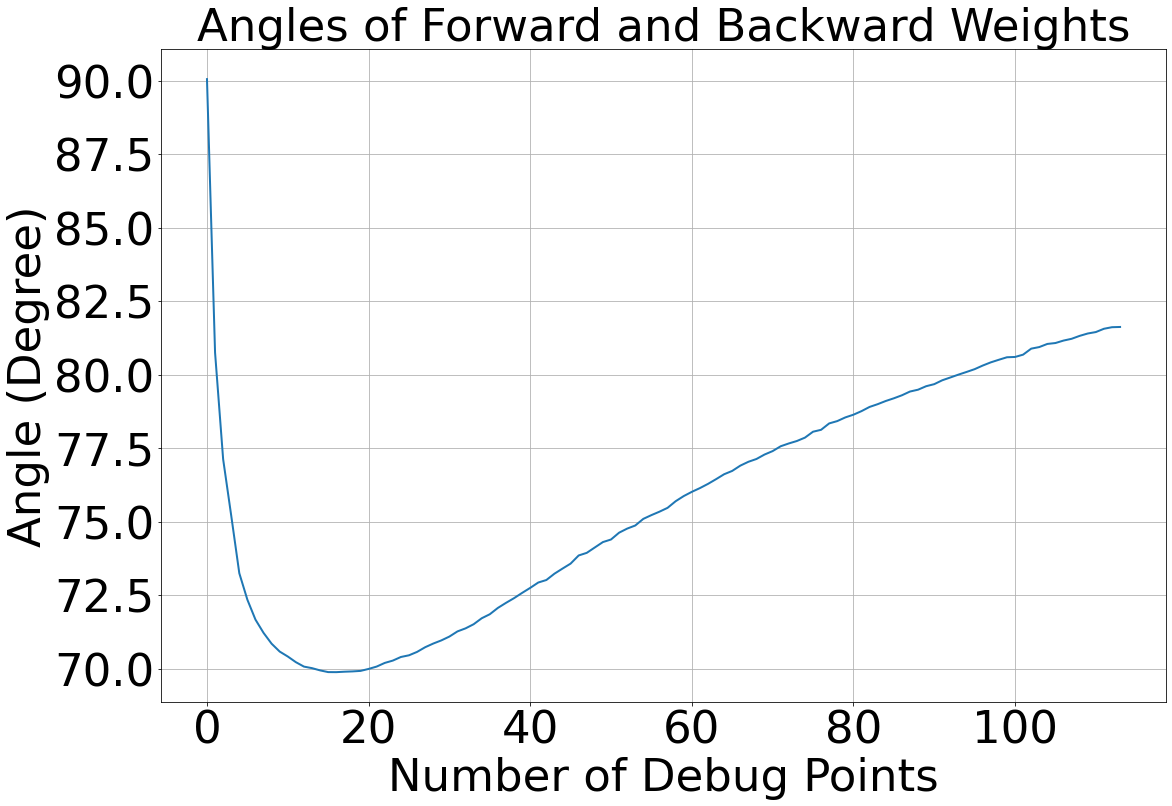

In [26]:
plt.figure(figsize = (18, 12))
plt.plot(model.forward_backward_angles, linewidth=2)
plt.xlabel("Number of Debug Points", fontsize=45)
plt.ylabel("Angle (Degree)", fontsize=45)
plt.title("Angles of Forward and Backward Weights", fontsize=45)
plt.grid()
plt.xticks(fontsize=45)
plt.yticks(fontsize=45)
plt.show()

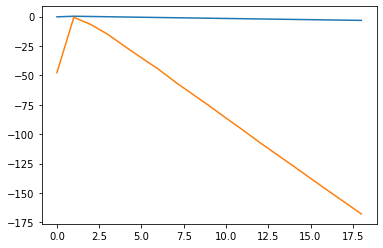

In [18]:
plt.plot(np.array(model.layerwise_forward_corinfo_list_nudged))# - np.array(model.layerwise_forward_corinfo_list_free))
# plt.show()

plt.plot(np.array(model.layerwise_backward_corinfo_list_nudged))# - np.array(model.layerwise_backward_corinfo_list_free))
# plt.show()



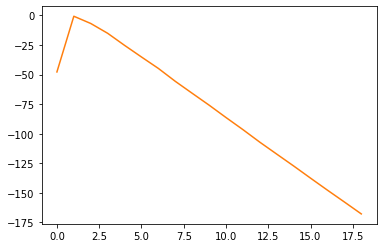

In [19]:
plt.plot(model.layerwise_backward_corinfo_list_free)
# plt.show()

plt.plot(model.layerwise_backward_corinfo_list_nudged)
plt.show()



In [ ]:
5

In [15]:
# model.layerwise_backward_corinfo_list_free, model.layerwise_backward_corinfo_list_nudged

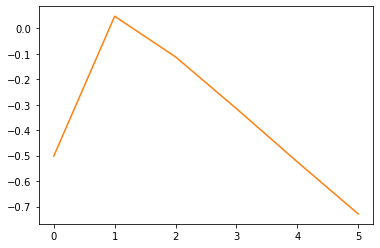

In [15]:
plt.plot(model.layerwise_forward_corinfo_list_free)
# plt.show()

plt.plot(model.layerwise_forward_corinfo_list_nudged)
plt.show()



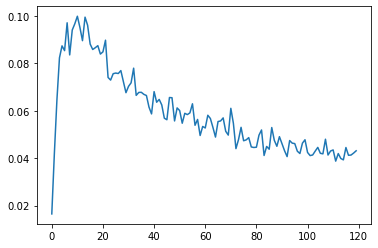

In [17]:
plt.plot(np.array(model.layerwise_forward_corinfo_list_free) / np.array(model.layerwise_backward_corinfo_list_free))

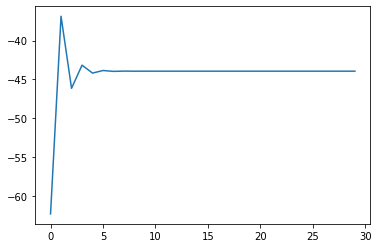

In [18]:
plt.plot(model.neural_dynamics_free_forward_info_list[8])

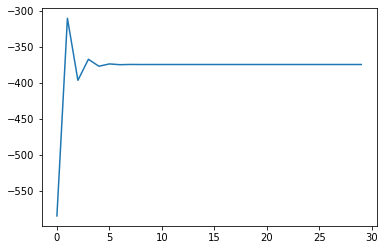

In [19]:
plt.plot(model.neural_dynamics_free_backward_info_list[5])

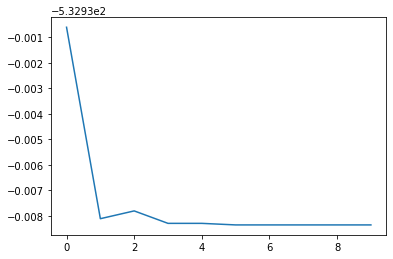

In [20]:
plt.plot(model.neural_dynamics_nudged_backward_info_list[10])

In [21]:
model.layerwise_forward_corinfo_list_nudged

[[-0.5723836421966553],
 [-12.354476928710938],
 [-23.24678611755371],
 [-28.977827072143555],
 [-32.79563903808594],
 [-31.92905044555664],
 [-36.84695816040039],
 [-34.98084259033203],
 [-43.87493133544922],
 [-42.75783920288086],
 [-53.217430114746094],
 [-50.486083984375],
 [-41.5759162902832],
 [-50.21199035644531],
 [-46.345088958740234],
 [-44.491268157958984],
 [-44.84934997558594],
 [-46.87738800048828],
 [-48.93721389770508],
 [-46.38496780395508],
 [-48.05594253540039],
 [-53.20217514038086],
 [-38.802032470703125],
 [-43.34989547729492],
 [-48.70357894897461],
 [-49.438655853271484],
 [-48.75530242919922],
 [-53.349395751953125],
 [-48.01948165893555],
 [-43.5160026550293],
 [-48.341766357421875],
 [-49.84435272216797],
 [-55.42311096191406],
 [-49.03413009643555],
 [-50.6007080078125],
 [-54.20766067504883],
 [-53.747310638427734],
 [-51.37038040161133],
 [-43.85066223144531],
 [-45.5890007019043],
 [-55.008758544921875],
 [-48.508766174316406],
 [-51.11688995361328],
 [-5

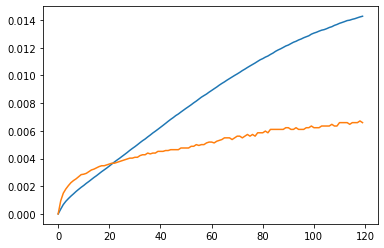

In [22]:
plt.plot(np.array(model.layerwise_forward_corinfo_list_nudged) - np.array(model.layerwise_forward_corinfo_list_free))
# plt.show()

plt.plot(np.array(model.layerwise_backward_corinfo_list_nudged) - np.array(model.layerwise_backward_corinfo_list_free))
# plt.show()



In [23]:
x,y = next(iter(train_loader))
x, y = x.to(device), y.to(device)
x = x.view(x.size(0),-1).T
y_one_hot = F.one_hot(y, 10).to(device).T

neurons = model.init_neurons(x.size(1), device = model.device)

neurons, _, _ = model.run_neural_dynamics_hopfield(x, y, neurons, hopfield_g, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                             neural_lr_decay_multiplier, neural_dynamic_iterations_free, 1)

layers = [x] + neurons
Wff = model.Wff
Wfb = model.Wfb
B = model.B
Rfree = model.Rfree
Rnudged = model.Rnudged
print(len(Wff), len(Wfb), len(B), len(Rfree), len(Rnudged))

2 2 2 2 2


In [24]:
torch.log(torch.det(Rnudged[0]['weight']))

tensor(-inf, device='cuda:0')

In [25]:
neurons[0].shape

torch.Size([500, 20])

In [26]:
torch.logdet(Rfree[2]['weight'])

IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
torch.norm(neurons[0] - (Wff[0]['weight'] @ x + Wff[0]['bias']))**2

In [ ]:
norm_check = 0
bs = neurons[0].shape[1]
for ii in range(bs):
    norm_check +=(lambda_ ** (bs - ii + 1)) * torch.norm((neurons[0] - (Wff[0]['weight'] @ x + Wff[0]['bias']))[:,ii])**2
    
norm_check

In [ ]:
torch.norm(neurons[1] - (Wff[1]['weight'] @ neurons[0] + Wff[1]['bias']))**2

In [ ]:
norm_check = 0
bs = neurons[0].shape[1]
for ii in range(bs):
    norm_check +=(lambda_ ** (bs - ii + 1)) * torch.norm((neurons[1] - (Wff[1]['weight'] @ neurons[0] + Wff[1]['bias']))[:,ii])**2
    
norm_check

In [ ]:
58.9840 / 13.4070

In [ ]:
233.0565 / 53.0576

In [ ]:
np.sqrt(20)

In [ ]:
np.log(epsilon), torch.log(torch.Tensor([epsilon]).to(device)) 

In [ ]:
(neurons[0] - (Wff[0]['weight'] @ x + Wff[0]['bias'])).shape

In [ ]:
norm_check = 0
bs = neurons[0].shape[1]
for ii in range(bs):
    norm_check +=(lambda_ ** (bs - ii + 1)) * torch.norm((neurons[0] - (Wff[0]['weight'] @ x + Wff[0]['bias']))[:,4])
    
norm_check

In [ ]:
lambda_

In [ ]:
torch.linalg.matrix_rank(R[0]['weight'])

In [ ]:
(torch.eye(*R[0]['weight'].shape).to(device))

In [ ]:
torch.logdet(R[0]['weight'] + epsilon * torch.eye(*R[0]['weight'].shape).to(device))

In [ ]:
torch.logdet(R[0]['weight'].type(torch.float64) + epsilon * torch.eye(*R[0]['weight'].shape).to(device))

In [ ]:
torch.float64

In [ ]:
torch2numpy(epsilon * torch.eye(*R[0]['weight'].shape).to(device)).shape

In [ ]:
np.linalg.det(torch2numpy(R[0]['weight']))

In [ ]:
np.linalg.det(torch2numpy(R[0]['weight'] + epsilon * torch.eye(*R[0]['weight'].shape).to(device))) == 0

In [ ]:
torch.linalg.matrix_rank(B[0]['weight'])

In [ ]:
np.linalg.det(torch2numpy(B[0]['weight']))

In [ ]:
torch.logdet(B[0]['weight'])

In [ ]:
forward_info_list = []
for jj in range(len(model.architecture) - 2):
    forward_info_jj = (torch.logdet(R[jj + 1]['weight'] + epsilon * torch.eye(*R[jj + 1]['weight'].shape).to(device)) - one_over_epsilon * torch.norm(layers[jj + 2] - Wff[jj + 1]['weight'] @ layers[jj + 1] - Wff[jj + 1]['bias']) ** 2).item()
    forward_info_list.append(forward_info_jj)
    
backward_info_list = []
for jj in range(len(model.architecture) - 2):
    backward_info_jj = (torch.logdet(R[jj]['weight'] + epsilon * torch.eye(*R[jj]['weight'].shape).to(device)) - one_over_epsilon * torch.norm(model.append_ones_row_vector_to_tensor(layers[jj + 1]) - Wfb[jj + 1]['weight'] @ layers[jj + 2]) ** 2).item()
    backward_info_list.append(backward_info_jj)

In [ ]:
forward_info_list, backward_info_list

In [ ]:
jj = -1
torch.logdet(torch.inverse(B[jj + 1]['weight']) + epsilon * torch.eye(*B[jj + 1]['weight'].shape).to(device))

In [ ]:
jj = -1
torch.logdet(torch.inverse(B[jj + 1]['weight'][:-1,:-1]) + epsilon * torch.eye(*B[jj + 1]['weight'][:-1,:-1].shape).to(device))

In [ ]:
jj = -1
torch.logdet(torch.inverse((B[jj + 1]['weight']) + epsilon * torch.eye(*B[jj + 1]['weight'].shape).to(device))[:-1,:-1])

In [ ]:
torch.logdet(torch.inverse(B[0]['weight']) + epsilon * torch.eye(*B[0]['weight'].shape).to(device)) - one_over_epsilon * torch.norm(model.append_ones_row_vector_to_tensor(layers[1]) - Wfb[1]['weight'] @ layers[2]) ** 2

In [ ]:
(Wff[1]['weight'] @ layers[1] -  Wff[1]['bias']).shape

In [ ]:
layers[2].shape

In [ ]:
torch.logdet(torch.inverse(B[1]['weight']) + epsilon * torch.eye(*B[1]['weight'].shape).to(device)) - one_over_epsilon * torch.norm(layers[2] - Wff[1]['weight'] @ layers[1] - Wff[1]['bias']) ** 2

In [ ]:
display_matrix(model.B[0]['weight'][:10,:10])

In [ ]:
display_matrix(torch.linalg.inv(model.R[0]['weight'])[:10,:10])

In [ ]:
# from torch_utils import *

In [ ]:
# def angle_between_two_matrices(A, B):
#     """Computes the angle between two matrices A and B.

#     Args:
#         A (torch.Tensor): Pytorch tensor of size m times n
#         B (torch.Tensor): Pytorch tensor of size m times n

#     Returns:
#         angle: angle between the matrices A and B. The formula is given by the following:
#                (180/pi) * acos[ Tr(A @ B.T) / sqrt(Tr(A @ A.T) * Tr(B @ B.T))] 
#     """

#     angle = (180 / torch.pi) * torch.acos(torch.trace(A @ B.T) / torch.sqrt(torch.trace(A @ A.T) * torch.trace(B @ B.T)))
#     return angle

In [ ]:
plt.plot(model.forward_backward_angles)

In [ ]:
angle_between_two_matrices(model.Wff[1]['weight'], model.Wfb[1]['weight'].T).item()

In [ ]:
# torch.norm(model.B[0]['weight'] - torch.linalg.inv(model.Rh1))

In [ ]:
# display_matrix(torch.linalg.inv(model.Rh2)[:10,:10])